In [34]:
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import numpy as np
import tensorflow as tf
import random
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Dense, RNN, LSTM, Flatten, TimeDistributed, LSTMCell
from tensorflow.keras.layers import RepeatVector, Conv2D, SimpleRNN, GRU, Reshape, ConvLSTM2D, Conv2DTranspose

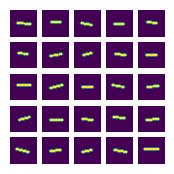

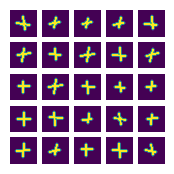

In [35]:
from scipy.ndimage import rotate


# Create plus/minus operand signs
def generate_images(number_of_images=50, sign='-'):
    blank_images = np.zeros([number_of_images, 28, 28])  # Dimensionality matches the size of MNIST images (28x28)
    x = np.random.randint(12, 16, (number_of_images, 2)) # Randomized x coordinates
    y1 = np.random.randint(6, 10, number_of_images)       # Randomized y coordinates
    y2 = np.random.randint(18, 22, number_of_images)     # -||-

    for i in range(number_of_images): # Generate n different images
        cv2.line(blank_images[i], (y1[i], x[i,0]), (y2[i], x[i, 1]), (255,0,0), 2, cv2.LINE_AA)     # Draw lines with randomized coordinates
        if sign == '+':
            cv2.line(blank_images[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA) # Draw lines with randomized coordinates
        if sign == '*':
            cv2.line(blank_images[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA)
            # Rotate 45 degrees
            blank_images[i] = rotate(blank_images[i], -50, reshape=False)
            cv2.line(blank_images[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA)
            blank_images[i] = rotate(blank_images[i], -50, reshape=False)
            cv2.line(blank_images[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA)

    return blank_images

def show_generated(images, n=5):
    plt.figure(figsize=(2, 2))
    for i in range(n**2):
        plt.subplot(n, n, i+1)
        plt.axis('off')
        plt.imshow(images[i])
    plt.show()

show_generated(generate_images())
show_generated(generate_images(sign='+'))

In [36]:
def create_data(highest_integer, num_addends=2, operands=['+', '-']):
    """
    Creates the following data for all pairs of integers up to [1:highest integer][+/-][1:highest_integer]:

    @return:
    X_text: '51+21' -> text query of an arithmetic operation (5)
    X_img : Stack of MNIST images corresponding to the query (5 x 28 x 28) -> sequence of 5 images of size 28x28
    y_text: '72' -> answer of the arithmetic text query
    y_img :  Stack of MNIST images corresponding to the answer (3 x 28 x 28)

    Images for digits are picked randomly from the whole MNIST dataset.
    """

    num_indices = [np.where(MNIST_labels==x) for x in range(10)]
    num_data = [MNIST_data[inds] for inds in num_indices]
    image_mapping = dict(zip(unique_characters[:10], num_data))
    image_mapping['-'] = generate_images()
    image_mapping['+'] = generate_images(sign='+')
    image_mapping['*'] = generate_images(sign='*')
    image_mapping[' '] = np.zeros([1, 28, 28])

    X_text, X_img, y_text, y_img = [], [], [], []

    for i in range(highest_integer + 1):      # First addend
        for j in range(highest_integer + 1):  # Second addend
            for sign in operands: # Create all possible combinations of operands
                query_string = to_padded_chars(str(i) + sign + str(j), max_len=max_query_length, pad_right=True)
                query_image = []
                for n, char in enumerate(query_string):
                    image_set = image_mapping[char]
                    index = np.random.randint(0, len(image_set), 1)
                    query_image.append(image_set[index].squeeze())

                result = eval(query_string)
                result_string = to_padded_chars(result, max_len=max_answer_length, pad_right=True)
                result_image = []
                for n, char in enumerate(result_string):
                    image_set = image_mapping[char]
                    index = np.random.randint(0, len(image_set), 1)
                    result_image.append(image_set[index].squeeze())

                X_text.append(query_string)
                X_img.append(np.stack(query_image))
                y_text.append(result_string)
                y_img.append(np.stack(result_image))

    return np.stack(X_text), np.stack(X_img)/255., np.stack(y_text), np.stack(y_img)/255.

def to_padded_chars(integer, max_len=3, pad_right=False):
    """
    Returns a string of len()=max_len, containing the integer padded with ' ' on either right or left side
    """
    length = len(str(integer))
    padding = (max_len - length) * ' '
    if pad_right:
        return str(integer) + padding
    else:
        return padding + str(integer)


(20000,) (20000, 5, 28, 28) (20000,) (20000, 3, 28, 28)
Query #507

X_text: "2-53 " = y_text: "-51"


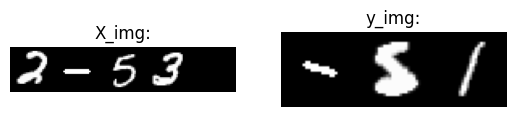

Query #7693

X_text: "38-46" = y_text: "-8 "


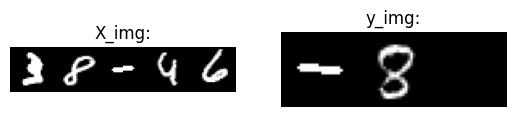

Query #5861

X_text: "29-30" = y_text: "-1 "


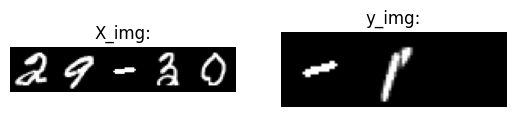

Query #851

X_text: "4-25 " = y_text: "-21"


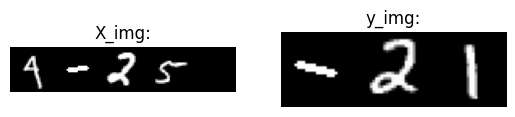

Query #5369

X_text: "26-84" = y_text: "-58"


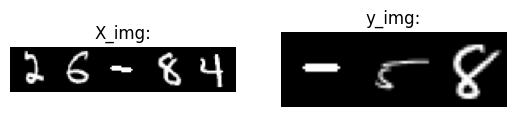

Query #4033

X_text: "20-16" = y_text: "4  "


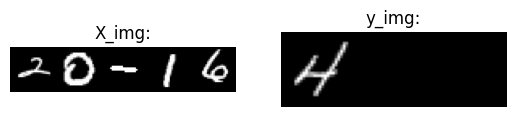

Query #1890

X_text: "9+45 " = y_text: "54 "


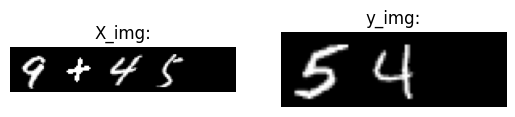

Query #5202

X_text: "26+1 " = y_text: "27 "


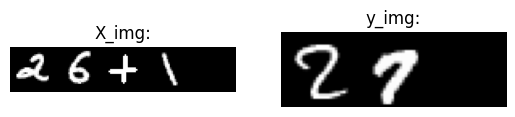

Query #5191

X_text: "25-95" = y_text: "-70"


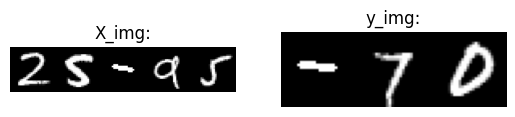

Query #4193

X_text: "20-96" = y_text: "-76"


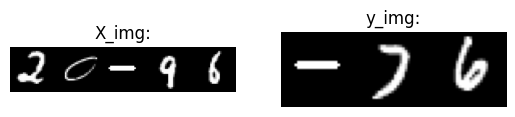

In [ ]:
# Illustrate the generated query/answer pairs

unique_characters = '0123456789+- '       # All unique characters that are used in the queries (13 in total: digits 0-9, 2 operands [+, -], and a space character ' '.)
highest_integer = 99                      # Highest value of integers contained in the queries

max_int_length = len(str(highest_integer))# Maximum number of characters in an integer
max_query_length = max_int_length * 2 + 1 # Maximum length of the query string (consists of two integers and an operand [e.g. '22+10'])
max_answer_length = 3    # Maximum length of the answer string (the longest resulting query string is ' 1-99'='-98')

# Create the data (might take around a minute)
(MNIST_data, MNIST_labels), _ = tf.keras.datasets.mnist.load_data()
X_text, X_img, y_text, y_img = create_data(highest_integer)
print(X_text.shape, X_img.shape, y_text.shape, y_img.shape)


## Display the samples that were created
def display_sample(n):
    labels = ['X_img:', 'y_img:']
    for i, data in enumerate([X_img, y_img]):
        plt.subplot(1,2,i+1)
        # plt.set_figheight(15)
        plt.axis('off')
        plt.title(labels[i])
        plt.imshow(np.hstack(data[n]), cmap='gray')
    print('='*50, f'\nQuery #{n}\n\nX_text: "{X_text[n]}" = y_text: "{y_text[n]}"')
    plt.show()

for _ in range(10):
    display_sample(np.random.randint(0, 10000, 1)[0])

In [38]:
# One-hot encoding/decoding the text queries/answers so that they can be processed using RNNs
# You should use these functions to convert your strings and read out the output of your networks

def encode_labels(labels, max_len=3):
  n = len(labels)
  length = len(labels[0])
  char_map = dict(zip(unique_characters, range(len(unique_characters))))
  one_hot = np.zeros([n, length, len(unique_characters)])
  for i, label in enumerate(labels):
      m = np.zeros([length, len(unique_characters)])
      for j, char in enumerate(label):
          m[j, char_map[char]] = 1
      one_hot[i] = m

  return one_hot


def decode_labels(labels):
    pred = np.argmax(labels, axis=1)
    predicted = ''.join([unique_characters[i] for i in pred])

    return predicted

X_text_onehot = encode_labels(X_text)
y_text_onehot = encode_labels(y_text)

print(X_text_onehot.shape, y_text_onehot.shape)

(20000, 5, 13) (20000, 3, 13)


## Text to Text model

In [39]:
def build_text2text_model():

    # We start by initializing a sequential model
    text2text = tf.keras.Sequential()

    # "Encode" the input sequence using an RNN, producing an output of size 256.
    # In this case the size of our input vectors is [5, 13] as we have queries of length 5 and 13 unique characters. Each of these 5 elements in the query will be fed to the network one by one,
    # as shown in the image above (except with 5 elements).
    # Hint: In other applications, where your input sequences have a variable length (e.g. sentences), you would use input_shape=(None, unique_characters).
    text2text.add(LSTM(256, input_shape=(None, len(unique_characters))))

    # As the decoder RNN's input, repeatedly provide with the last output of RNN for each time step. Repeat 3 times as that's the maximum length of the output (e.g. '  1-99' = '-98')
    # when using 2-digit integers in queries. In other words, the RNN will always produce 3 characters as its output.
    text2text.add(RepeatVector(max_answer_length))

    # By setting return_sequences to True, return not only the last output but all the outputs so far in the form of (num_samples, timesteps, output_dim). This is necessary as TimeDistributed in the below expects
    # the first dimension to be the timesteps.
    text2text.add(LSTM(256, return_sequences=True))

    # Apply a dense layer to the every temporal slice of an input. For each of step of the output sequence, decide which character should be chosen.
    text2text.add(TimeDistributed(Dense(len(unique_characters), activation='softmax')))

    # Next we compile the model using categorical crossentropy as our loss function.
    text2text.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    text2text.summary()

    return text2text

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_9 (LSTM)                   │ (None, 256)            │       276,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_8 (RepeatVector)  │ (None, 3, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (None, 3, 256)         │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_8              │ (None, 3, 13)          │         3,341 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 805,133 (3.07 MB)

 Trainable params: 805,133 (3.07 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.3115 - loss: 2.1111 - val_accuracy: 0.4199 - val_loss: 1.5964
Epoch 2/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.4500 - loss: 1.5304 - val_accuracy: 0.4951 - val_loss: 1.3840
Epoch 3/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.5191 - loss: 1.3201 - val_accuracy: 0.4895 - val_loss: 1.3482
Epoch 4/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5557 - loss: 1.2166 - val_accuracy: 0.5953 - val_loss: 1.1349
Epoch 5/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5880 - loss: 1.1378 - val_accuracy: 0.5784 - val_loss: 1.1327
Epoch 6/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5986 - loss: 1.0973 - val_accuracy: 0.6102 - val_loss: 1.0571
Epoch 7/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6185 - loss: 1.0427 - val_accuracy: 0.5915 - val_loss: 1.0925
Epoch 8/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6199 - loss: 1.0226 - val_accura

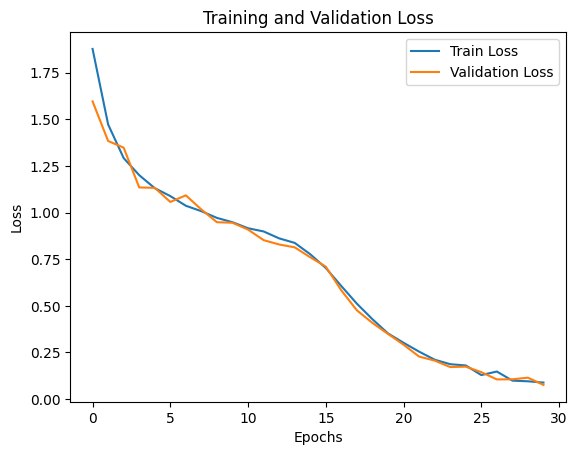

In [59]:
# Build the model
text2text_model = build_text2text_model()

# One-hot encode the labels for training
X_text_onehot = encode_labels(X_text, max_len=max_query_length)
y_text_onehot = encode_labels(y_text, max_len=max_answer_length)

# Split data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_text_onehot, y_text_onehot, test_size=0.2, random_state=42
)

# Add Early Stopping to monitor validation loss
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Train the model
history = text2text_model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=30,        # Maximum number of epochs to train
    batch_size=64,    # Batch size for training
    callbacks=[early_stop]
)

# Plot the training history
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


I want to test if this model is working and predicting correctly:



In [60]:
# Decode the labels from one-hot to text
def decode_labels(labels):
    """
    Decode one-hot encoded labels into their original string representation.
    """
    decoded = []
    for seq in labels:  # Iterate over each sequence
        pred = np.argmax(seq, axis=1)  # Find the index of the max value for each timestep
        predicted = ''.join([unique_characters[i] for i in pred])  # Convert indices to characters
        decoded.append(predicted)
    return decoded

# Predict on the test data
predictions = text2text_model.predict(X_test)

# Decode predictions and ground truths
decoded_predictions = decode_labels(predictions)
decoded_ground_truths = decode_labels(y_test)

# Display a few test samples with predictions
print("Sample Predictions:")
for i in range(5):  # Adjust the range for the number of examples you want to display
    print(f"Test Query #{i + 1}")
    input_query = ''.join([unique_characters[np.argmax(x)] for x in X_test[i]])  # Decode input query
    print(f"Input Query: {input_query}")
    print(f"True Output: {decoded_ground_truths[i]}")
    print(f"Predicted Output: {decoded_predictions[i]}")
    print("=" * 50)

# Calculate test accuracy
correct = sum([pred.strip() == true.strip() for pred, true in zip(decoded_predictions, decoded_ground_truths)])
accuracy = correct / len(decoded_predictions)
print(f"Test Accuracy: {accuracy * 100:.2f}%")


125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Sample Predictions:
Test Query #1
Input Query: 53+25
True Output: 78 
Predicted Output: 78 
Test Query #2
Input Query: 10-20
True Output: -10
Predicted Output: -10
Test Query #3
Input Query: 43+34
True Output: 77 
Predicted Output: 77 
Test Query #4
Input Query: 5+57 
True Output: 62 
Predicted Output: 62 
Test Query #5
Input Query: 69+51
True Output: 120
Predicted Output: 120
Test Accuracy: 96.23%


## Image to text model

In [61]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    ConvLSTM2D, BatchNormalization, MaxPooling3D, Dropout,
    Flatten, RepeatVector, LSTM, TimeDistributed, Dense
)
from tensorflow.keras import regularizers
def build_image2text_model_optimized(input_shape, vocab_size, max_answer_length):
    image2text = Sequential()

    # ConvLSTM2D Encoder
    image2text.add(ConvLSTM2D(
        filters=16,
        kernel_size=(3, 3),
        activation='relu',
        padding='same',
        return_sequences=True,
        input_shape=input_shape,
        kernel_regularizer=regularizers.l2(0.001)
    ))
    image2text.add(BatchNormalization())
    image2text.add(MaxPooling3D(pool_size=(1, 2, 2)))
    image2text.add(Dropout(0.2))

    image2text.add(ConvLSTM2D(
        filters=32,
        kernel_size=(3, 3),
        activation='relu',
        padding='same',
        return_sequences=False,
        kernel_regularizer=regularizers.l2(0.001)
    ))
    image2text.add(BatchNormalization())
    image2text.add(Dropout(0.2))

    # Flatten and Prepare for Decoding
    image2text.add(Flatten())
    image2text.add(RepeatVector(max_answer_length))

    # LSTM Decoder
    image2text.add(LSTM(128, return_sequences=True))
    image2text.add(Dropout(0.2))

    # Output Layer
    image2text.add(TimeDistributed(Dense(vocab_size, activation='softmax')))

    # Compile Model
    image2text.compile(
        loss='categorical_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        metrics=['accuracy']
    )

    image2text.summary()
    return image2text


X_train shape: (16000, 5, 28, 28, 1)
X_test shape: (4000, 5, 28, 28, 1)
y_train shape: (16000, 3, 13)
y_test shape: (4000, 3, 13)


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_lstm2d_16 (ConvLSTM2D)     │ (None, 5, 28, 28, 16)  │         9,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 5, 28, 28, 16)  │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_7 (MaxPooling3D)  │ (None, 5, 14, 14, 16)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 5, 14, 14, 16)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_17 (ConvLSTM2D)     │ (None, 14, 14, 32)     │        55,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 14, 14, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_9 (RepeatVector)  │ (None, 3, 6272)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 3, 128)         │     3,277,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 3, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_9              │ (None, 3, 13)          │         1,677 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,344,461 (12.76 MB)

 Trainable params: 3,344,365 (12.76 MB)

 Non-trainable params: 96 (384.00 B)

Epoch 1/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 39s 73ms/step - accuracy: 0.2853 - loss: 2.2916 - val_accuracy: 0.2850 - val_loss: 2.1791 - learning_rate: 0.0010
Epoch 2/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 37s 75ms/step - accuracy: 0.3884 - loss: 1.8817 - val_accuracy: 0.3989 - val_loss: 1.8044 - learning_rate: 0.0010
Epoch 3/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 37s 74ms/step - accuracy: 0.4074 - loss: 1.7582 - val_accuracy: 0.4023 - val_loss: 1.8158 - learning_rate: 0.0010
Epoch 4/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 37s 75ms/step - accuracy: 0.4258 - loss: 1.6836 - val_accuracy: 0.4222 - val_loss: 1.7147 - learning_rate: 0.0010
Epoch 5/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 38s 76ms/step - accuracy: 0.4454 - loss: 1.6315 - val_accuracy: 0.4288 - val_loss: 1.6780 - learning_rate: 0.0010
Epoch 6/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 39s 77ms/step - accuracy: 0.4630 - loss: 1.5705 - val_accuracy: 0.4368 - val_loss: 1.6312 - learning_rate: 0.0010
Epoch 7/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 39s 78ms/step - accuracy: 0.4866 - l

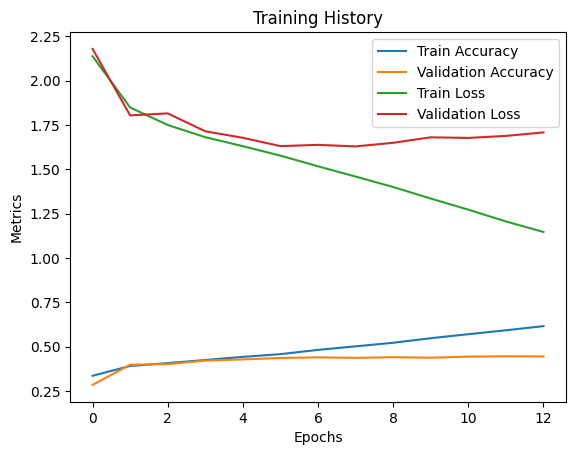

In [62]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Define highest_integer as per the earlier setup
highest_integer = 99

# Load the data
X_text, X_img, y_text, y_img = create_data(highest_integer)

# One-hot encode the labels
y_text_onehot = encode_labels(y_text, max_answer_length)

# Assuming X_img and y_text_onehot were created using your `create_data` function
from sklearn.model_selection import train_test_split

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_img, y_text_onehot, test_size=0.2, random_state=42
)

# Add channel dimension for ConvLSTM2D
X_train = np.expand_dims(X_train, axis=-1)  # Adds a channel dimension
X_test = np.expand_dims(X_test, axis=-1)

# Ensure shapes are correct
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

# Build and compile the model
vocab_size = len(unique_characters)
input_shape = (max_query_length, 28, 28, 1)  # Includes channel dimension
max_answer_length = 3  # Maximum length of the output sequence

# Assuming build_image2text_model_optimized is correctly defined
model = build_image2text_model_optimized(input_shape, vocab_size, max_answer_length)

batch_size = 32
epochs = 30
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1),
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
]

history = model.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_test, y_test),
    callbacks=callbacks
)

# Plot training history
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Training History")
plt.xlabel("Epochs")
plt.ylabel("Metrics")
plt.show()


In [63]:
def decode_labels(labels, unique_characters):
    """
    Decodes one-hot encoded labels into their original string representation.
    """
    idx_to_char = {idx: char for idx, char in enumerate(unique_characters)}
    decoded = [''.join([idx_to_char[np.argmax(char)] for char in seq]) for seq in labels]
    return decoded


In [64]:
# Predict using the trained model
predictions = model.predict(X_test)

# Decode predictions and true labels
decoded_predictions = decode_labels(predictions, unique_characters)
decoded_ground_truths = decode_labels(y_test, unique_characters)


125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step


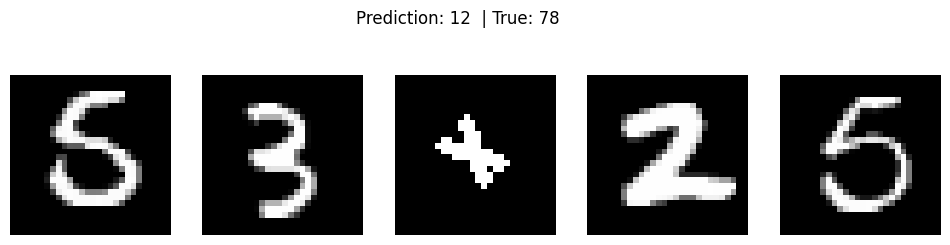

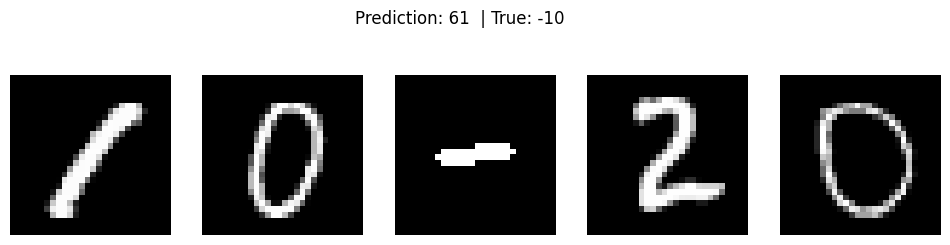

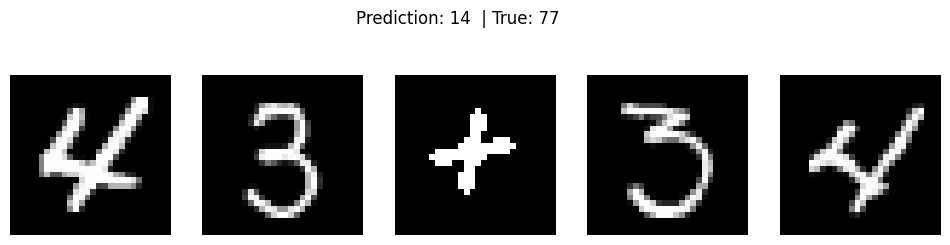

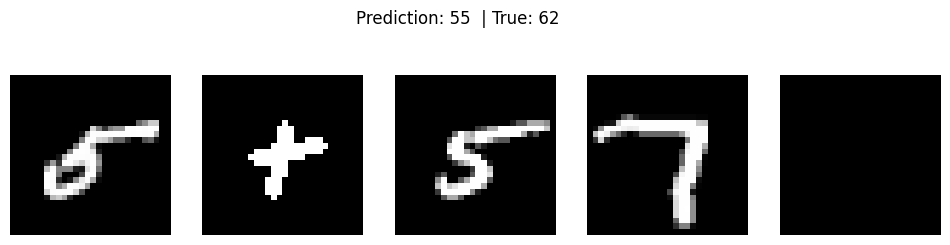

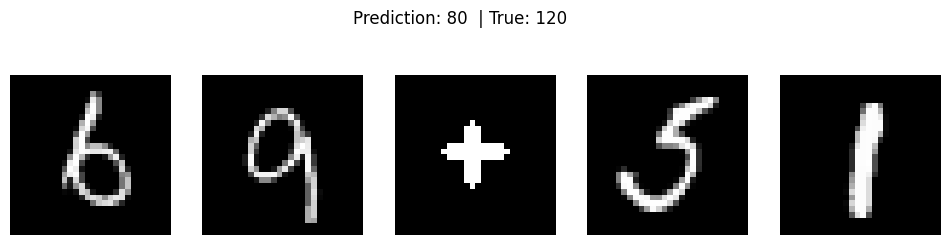

In [65]:
import matplotlib.pyplot as plt

# Display a few test samples and their predictions
for i in range(5):  # Adjust the range to display more or fewer samples
    plt.figure(figsize=(12, 3))
    
    # Display the query images
    for j in range(max_query_length):
        plt.subplot(1, max_query_length, j + 1)
        plt.imshow(X_test[i, j, :, :, 0], cmap="gray")  # Extract single channel
        plt.axis("off")
    
    # Show predictions and ground truths
    plt.suptitle(f"Prediction: {decoded_predictions[i]} | True: {decoded_ground_truths[i]}")
    plt.show()


In [66]:
correct = 0
total = len(decoded_predictions)

for pred, true in zip(decoded_predictions, decoded_ground_truths):
    if pred.strip() == true.strip():  # Compare after stripping whitespace
        correct += 1

accuracy = correct / total
print(f"Test Accuracy: {accuracy * 100:.2f}%")


Test Accuracy: 1.62%
